# Infer ***nuclei*** - 2️⃣ 

--------------

## OBJECTIVE: ✅ Infer sub-cellular component #2: ***nuclei***  in order to understand interactome 

To measure shape, position, size, and interaction of eight organelles/cellular components ***nuclei***.  

Dependencies:
***Soma*** and ***cytosol*** inference rely on the ***nuclei*** inference.  Therefore all of the sub-cellular objects rely on the NU segmentation.





# IMPORTS

In [41]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np

from aicssegmentation.core.pre_processing_utils import  image_smoothing_gaussian_slice_by_slice 
from aicssegmentation.core.utils import hole_filling
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    list_image_files)
from infer_subc_2d.utils.img import *
from infer_subc_2d.organelles import fixed_get_optimal_Z_image, fixed_find_optimal_Z, find_optimal_Z
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH, 
                                                                    ALL_CHANNELS )          

from infer_subc_2d.organelles import infer_soma, fixed_infer_soma

%load_ext autoreload
%autoreload 2

test_img_n = TEST_IMG_N

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IMAGE PROCESSING  OBJECTIVE :  infer ***nuclei***
 

NOTE:  using Allen Cell Segmenter  [Nucleophosmin](https://www.allencell.org/cell-observations/category/nucleophosmin) might be a good generic mechanism.  e.g.
-  [playground_npm1.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_npm1.ipynb) and [npm1.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_npm1.py) and [npm1_SR.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_npm1_SR.py)


> #### Note:  this initial inferred object -- the ***nuclei*** of the brightest cell -- is implicitly used in inferring the ***soma*** and ***cytosol*** objects.  


------------------------
# LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [42]:
# build the datapath
# all the imaging data goes here.
# CUSTOMIZE HERE --->
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [43]:
img_data,meta_dict = read_czi_image(test_img_name)


# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']



/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [10]:
# make sure we have removed Z
if len(scale)>2:
    scale = scale[1:]

## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [11]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 




Now get the single "optimal" slice of all our organelle channels....

In [12]:

# img_2D = img_data[:,[optimal_Z],:,:].copy()
img_2D = select_z_from_raw(img_data, optimal_Z)

soma_mask =  fixed_infer_soma(img_2D) 

... and visualize.

In [13]:
viewer = napari.Viewer()

viewer.add_image(soma_mask,
    scale=scale)

<Image layer 'soma_mask' at 0x16553eca0>


# IMAGE PROCESSING PROTOTYPE, Objective 2:  infer NUCLEI
 
## details

➡️ INPUT

- channel 0

PRE-PROCESSING
-  scale to min 0, max 1.0
- median Filter window 4
-  gaussian 1.34

CORE-PROCESSING
  - threshold method minimum cross-entropy.  
    - objects 50-400 pixels, 
    - threshold smoothing scale: 1.34 (later 1 pixel
    - threshold correction factor: 0.9 (later 1.2 )
    - lower / upper bounds  (.1,1) ?
    - log transformed thresholding
    - fill holes


POST-PROCESSING
  - fill holes
  - remove small objects


OUTPUT ➡️ 
- labels of NUCLEI


> #### Note:  in later steps we will limit each analysis to a single object, but at this stage we have multiple


DATA IMPORT

Get the "raw" signals we need to analyze as well as any other dependencies in "inferred" objects.  

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.

## PRE- PROCESSING

In [14]:
###################
# INPUT
###################
# raw_nuclei = img_2D[NUC_CH].copy()
raw_nuclei = select_channel_from_raw(img_2D, NUC_CH)


In [15]:
###################
# PRE_PROCESSING
###################           
# 
nuclei = min_max_intensity_normalization(raw_nuclei )

med_filter_size = 4   
# structure_img_median_3D = ndi.median_filter(struct_img,    size=med_filter_size  )
nuclei = median_filter_slice_by_slice( 
                                                                nuclei,
                                                                size=med_filter_size  )

gaussian_smoothing_sigma = 1.34
nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei,
                                                                                            sigma=gaussian_smoothing_sigma)




> #### NOTE: Thresholding
> [Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. In many cases, images can be adequately segmented by thresholding followed by labelling of *connected components*, which is a fancy way of saying "groups of pixels that touch each other".
> 
> Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. Below, we use Li. You can use `skimage.filters.threshold_<TAB>` to find different thresholding methods.

_Li_ procedure  better matches the CellProfiler pipeline which simply calls it "Minimum Cross Entropy" .


## CORE PROCESSING

In [17]:

###################
# CORE_PROCESSING
###################

threshold_factor = 0.9 #from cellProfiler
thresh_min = .1
thresh_max = 1.
li_thresholded = apply_log_li_threshold(nuclei, thresh_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)


## POST PROCESSING

> NOTE: the size parameters are by convention defined as one dimensional "width", so the inputs to the functions need to be _squared_ i.e. raised to the power of 2: `** 2`.   For volumetric (3D) analysis this would be _cubed_:`**3`

In [18]:
###################
# POST_PROCESSING
###################

hole_width = 5  
# # wrapper to remoce_small_objects
#removed_holes = remove_small_holes(li_thresholded, hole_width ** 2 )
removed_holes = hole_filling(li_thresholded, hole_min=0, hole_max=hole_width**2, fill_2d=True)

small_object_width = 15
cleaned_img = size_filter_2D(removed_holes, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width ** 2, 
                                                         connectivity=1)


OUTPUT + Visualize Results

In [19]:
nuclei_object = cleaned_img
NU_labels = label( cleaned_img )
NU_signal = raw_nuclei

In [20]:

viewer.add_image(
    nuclei_object,
    scale=scale,
    opacity=0.3,
)    


viewer.add_labels(
    NU_labels,
    scale=scale,
    opacity=0.3,
)



<Labels layer 'NU_labels' at 0x171490040>

# DEFINE `_infer_nuclei` function

Based on the _prototyping_ above define the function to infer nuclei.  

> NOTE:  although it takes the parameters as input, they are all "hard coded" below, and the function returns the parameters in the same `defaultdict`

In [21]:
from typing import Optional


In [22]:
##########################
#  _infer_nuclei
##########################
def _infer_nuclei( in_img: np.ndarray, 
                            soma_mask: np.ndarray,
                            median_sz: int, 
                            gauss_sig: float,
                            thresh_factor: float,
                            thresh_min: float,
                            thresh_max: float,
                            max_hole_w: int,
                            small_obj_w: int
                        ) -> np.ndarray:
    """
    Procedure to infer nuclei from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: Optional[np.ndarray] = None
        mask
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w: int
        hole filling cutoff for nuclei post-processing
    small_obj_w: int
        minimu object size cutoff for nuclei post-processing

    Returns:
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    ###################
    # PRE_PROCESSING
    ###################                
    nuc_ch = NUC_CH
    nuclei = select_channel_from_raw(in_img, nuc_ch)
    nuclei = min_max_intensity_normalization( nuclei )

    nuclei = median_filter_slice_by_slice( nuclei,
                                                                    size=median_sz  )

    nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei,
                                                                                                sigma=gauss_sig )

    ###################
    # CORE_PROCESSING
    ###################
    nuclei_object = apply_log_li_threshold(nuclei, 
                                                                    thresh_factor=thresh_factor, 
                                                                    thresh_min=thresh_min, 
                                                                    thresh_max=thresh_max)


    NU_labels = label(nuclei_object)
    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = hole_filling(nuclei_object, 
                                                    hole_min=0, 
                                                    hole_max=max_hole_w, 
                                                    fill_2d=True)

    if soma_mask is not None:
        nuclei_object = apply_mask(nuclei_object, soma_mask)

    nuclei_object = size_filter_2D(nuclei_object, 
                                                                min_size = small_obj_w, 
                                                                connectivity=1)

    return nuclei_object


In [23]:
##########################
#  fixed_infer_nuclei
##########################
def _fixed_infer_nuclei(in_img: np.ndarray, soma_mask: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: np.ndarray
        mask
 
    Returns:
    -------------
    nuclei_object
        mask defined extent of NU
    
    """
    nuc_ch = NUC_CH
    median_sz = 4   
    gauss_sig = 1.34
    threshold_factor = 0.9
    thresh_min = 0.1
    thresh_max = 1.0
    max_hole_w = 5
    small_obj_w = 15

    return _infer_nuclei( in_img,
                                    soma_mask,
                                    median_sz,
                                    gauss_sig,
                                    threshold_factor,
                                    thresh_min,
                                    thresh_max,
                                    max_hole_w,
                                    small_obj_w  )


---------------------
# TEST `_infer_nuclei`  function defined above


##


In [24]:

_NU_object =  _fixed_infer_nuclei(img_2D, soma_mask) 



In [25]:
viewer.add_image(
    _NU_object,
    scale=scale,
    opacity=0.3,
)    


viewer.add_labels(
    label(_NU_object),
    scale=scale,
    opacity=0.3,
)


<Labels layer 'Labels' at 0x171febdf0>

---------------------
# TEST `infer_nuclei` exported functions

> the prototype `_infer_nuclei` was copied to the [`.organelles.nuclei`](../infer_subc_2d/organelles/nuclei.py) sub-module 
##
`infer_nuclei` procedure

Use the `infer_nuclei` function to infer the Nucleus and export it as an _ome.tif_ for easy reference.

In [26]:
# from infer_subc_2d.organelles.nuclei import infer_nuclei, fixed_infer_nuclei

nuclei_object =  _fixed_infer_nuclei(img_2D, soma_mask) 


In [27]:
viewer.add_image(
    nuclei_object,
    scale=scale,
    opacity=0.3,
)    



<Image layer 'nuclei_object [1]' at 0x1721cfa00>

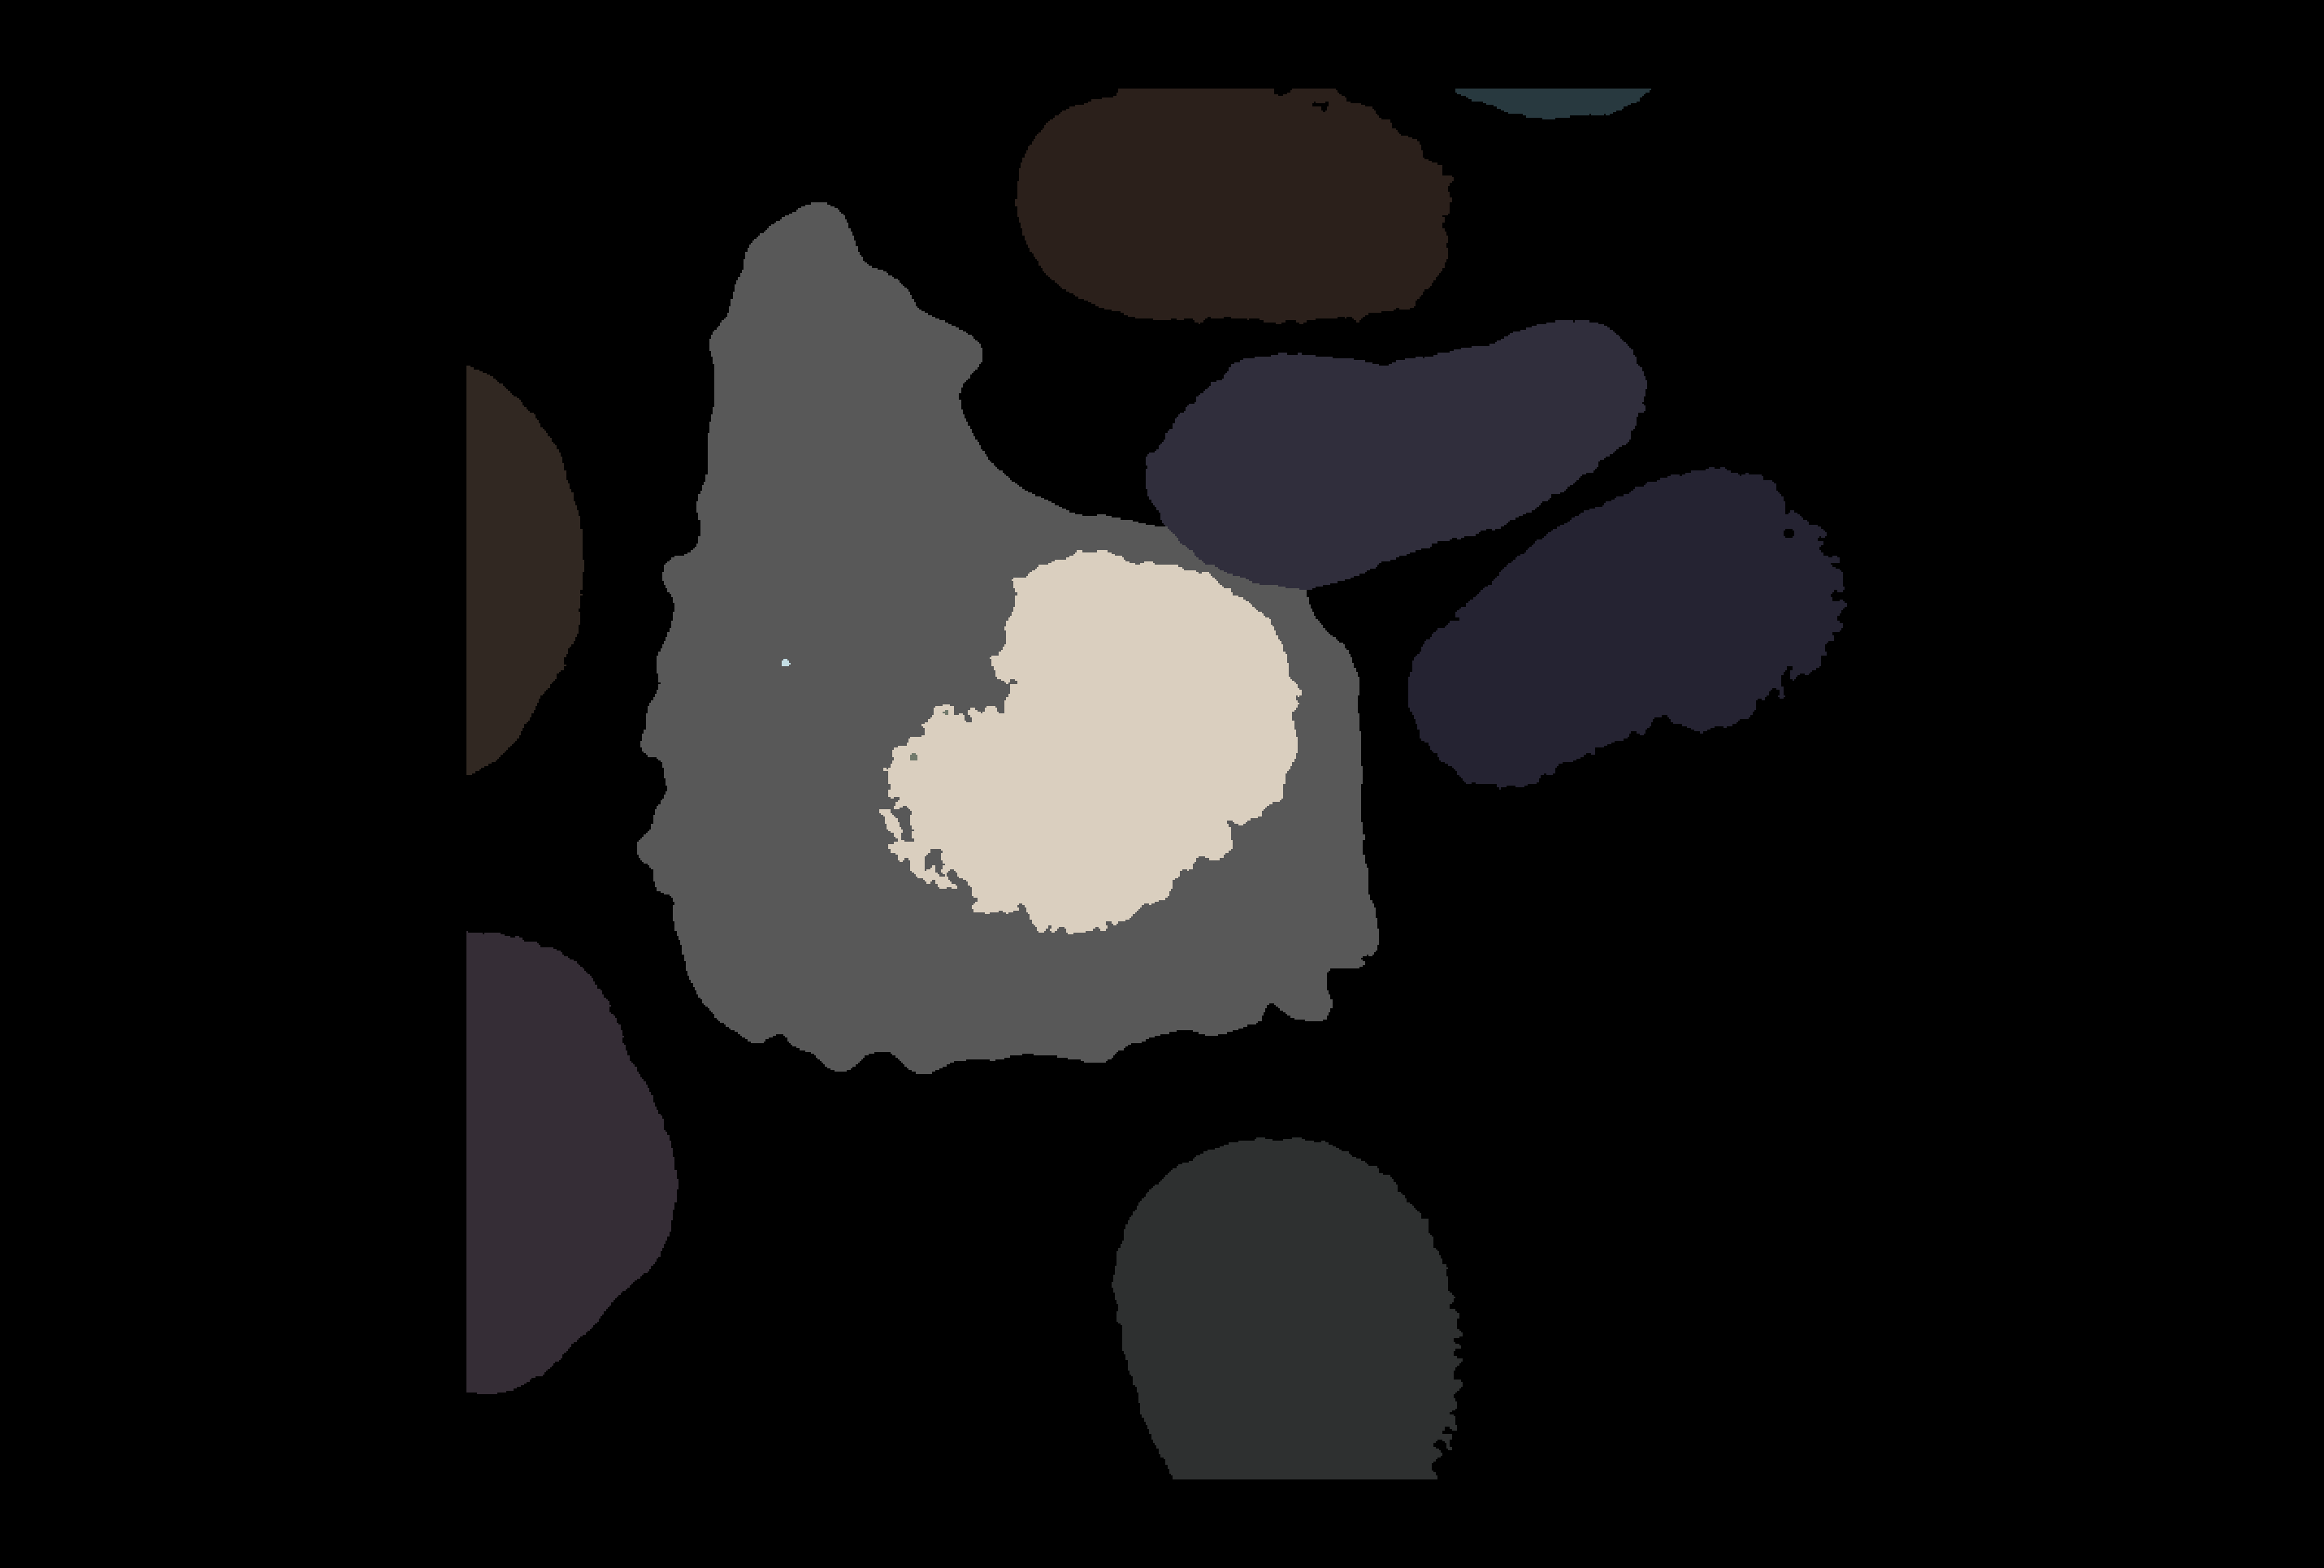

In [28]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

-----------------
## make function json to add to `all_functions.json`
### infer_nuclei 

In [50]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_nuclei =  {
        "name": "infer nuclei  (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_nuclei",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_nuclei",_fixed_infer_nuclei)

function fixed_infer_nuclei is already in all_functions.json


0

In [51]:

_infer_nuclei =  {
        "name": "infer nuclei",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_nuclei",
        "parameters": {
                "median_sz": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "thresh_factor": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.2,
                        "min": 0.6,
                        "widget_type": "slider"
                },
                "thresh_min": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": .9,
                        "min": 0.0,
                        "widget_type": "slider"
                },
                "thresh_max": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.0,
                        "min": 0.1,
                        "widget_type": "slider"
                },
                "max_hole_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 40,
                        "min": 4,
                        "widget_type": "slider"
                },           
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_nuclei", _infer_nuclei, overwrite=True )



function infer_nuclei is already in all_functions.json
overwriting  infer_nuclei


1

In [52]:
_median_filter_slice_by_slice =  {
                "name": "Median Smoothing Slice by Slice",
                "python::module": "infer_subc_2d.utils.img",
                "python::function": "median_filter_slice_by_slice",
                "parameters": {
                    "size": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 1,
                        "max": 20,
                        "increment": 1
                    }
                }
            } 
add_function_spec_to_widget_json("median_filter_slice_by_slice",_median_filter_slice_by_slice)

function median_filter_slice_by_slice is already in all_functions.json


0

In [53]:

    # gaussian_smoothing_sigma = 1.34
    # gaussian_smoothing_truncate_range = 3.0
    # nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei,
    #                                                                                             sigma=gaussian_smoothing_sigma,
    #                                                                                             truncate_range = gaussian_smoothing_truncate_range
    #                                                                                             )
_image_smoothing_gaussian_slice_by_slice = {
        "name": "Gaussian Smoothing Slice by Slice",
        "python::module": "aicssegmentation.core.pre_processing_utils",
        "python::function": "image_smoothing_gaussian_slice_by_slice",
        "parameters": {
            "sigma": {
                "widget_type": "slider",
                "data_type": "float",
                "min": 0.8,
                "max": 20,
                "increment": 0.2
            }
        }
        }

# json.dumps({"image_smoothing_gaussian_slice_by_slice": _image_smoothing_gaussian_slice_by_slice} )
add_function_spec_to_widget_json("image_smoothing_gaussian_slice_by_slice",_image_smoothing_gaussian_slice_by_slice)        


function image_smoothing_gaussian_slice_by_slice is already in all_functions.json


0

In [54]:

    # threshold_factor = 0.9 #from cellProfiler
    # thresh_min = .1
    # thresh_max = 1.
    # nuclei_object = apply_log_li_threshold(nuclei, threshold_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)

# WARNING: not a good way to set to None
_apply_log_li_threshold = {
        "name": "threshold log Li",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "apply_log_li_threshold",
        "parameters": {
            "thresh_factor": {
                "widget_type": "slider",
                "data_type": "float",
                "min": 0.3,
                "max": 1.1,
                "increment": 0.05
            },
            "thresh_min": {
                "widget_type": "slider",
                "data_type": "float",
                "min": 0.0,
                "max": 0.8,
                "increment": 0.01
            },
            "thresh_max": {
                "widget_type": "slider",
                "data_type": "float",
                "min": 0.3,
                "max": 1.0,
                "increment": 0.05
            },
        }
        }

# json.dumps({"apply_log_li_threshold": _apply_log_li_threshold} )
add_function_spec_to_widget_json("apply_log_li_threshold",_apply_log_li_threshold,overwrite=True)        


function apply_log_li_threshold is already in all_functions.json
overwriting  apply_log_li_threshold


1

In [55]:


    # NU_labels = label(nuclei_object)

_label =  {
        "name": "label objects",
        "python::module": "skimage.measure",
        "python::function": "label",
        "parameters": None
        }
# json.dumps({"label":_label})
add_function_spec_to_widget_json("label",_label)        


function label is already in all_functions.json


0

In [56]:

#  nulei_object = apply_mask(nuclei_object, soma_mask)

_apply_mask=  {
        "name": "apply mask",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "apply_mask",
        "parameters": None
        }
# json.dumps({"apply_mask":_apply_mask})
add_function_spec_to_widget_json("apply_mask",_apply_mask)        


function apply_mask is already in all_functions.json


0

In [57]:

    # small_object_width = 45
    # nuclei_object = size_filter_2D(nuclei_object, 
    #                                                             min_size= small_object_width**2, 
    #                                                             connectivity=1)


_size_filter_2D = {
        "name": "Size Filter 2D",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "size_filter_2D",
        "parameters": {
            "min_size": {
                "widget_type": "slider",
                "data_type": "int",
                "min": 0,
                "max": 500,
                "increment": 1
            }
        }
    }
# json.dumps({  "size_filter_2D":  _size_filter_2D   })

add_function_spec_to_widget_json("size_filter_2D",_size_filter_2D)        


function size_filter_2D is already in all_functions.json


0

## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [58]:
from infer_subc_2d.constants import NUC_CH
def make_infer_nuclei_dict():
    """
    Procedure to infer nuclei from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    soma_mask: np.ndarray
        mask

    Returns:
    -------------
    nuclei_object
        mask defined extent of NU

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   
    step_name.append("1")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = NUC_CH) )
    parent.append(0)

    ###################
    # PRE_PROCESSING
    ###################                         
    # nuclei = min_max_intensity_normalization(in_img[NUC_CH].copy() )
    step_name.append("2")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(1)

    # size = 4   
    # nuclei = median_filter_slice_by_slice( 
    #                                                                 nuclei,
    #                                                                 size=size  )
    step_name.append("3")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(2)

    # sigma = 1.34
    # truncate_range = 3.0
    # nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei,
    #                                                                                             sigma=sigma,
    #                                                                                             truncate_range = truncate_range
    #                                                                                             )
    step_name.append("4")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.34 ))
    parent.append(3)

    ###################
    # CORE_PROCESSING
    ###################
    # threshold_factor = 0.9 
    # thresh_min = .1
    # thresh_max = 1.
    # nuclei_object = apply_log_li_threshold(nuclei, threshold_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)
    step_name.append("5")
    function_name.append("apply_log_li_threshold")
    category.append("core")
    parameter_values.append(dict(thresh_factor = 0.9, 
                                                            thresh_min = .1,
                                                            thresh_max = 1.))
    parent.append(4)


    # NU_labels = label(nuclei_object)
    step_name.append("6")
    function_name.append("label")
    category.append("core")
    parameter_values.append(None)
    parent.append(5)


    ###################
    # POST_PROCESSING
    ###################
    # hole_width = 5  
    # nuclei_object = hole_filling(nuclei_object, hole_min=0, hole_max=hole_width**2, fill_2d=True)
    step_name.append("6")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=5**2, fill_2d=True))
    parent.append(5)

    # # EEEEEK I don't know how to compose where the mask comes from... 
    # nuclei_object = apply_mask(nuclei_object, soma_mask)

    # small_object_width = 15
    # nuclei_object = size_filter_2D(nuclei_object, 
    #                                                             min_size= small_object_width**2, 
    #                                                             connectivity=1)
    step_name.append("7")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(6)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [59]:
def _write_workflow_json(wf_name, wf_dict):

    # read all_functions.json into dict
    # if not wf_name.startswith("conf"):
    #     wf_name = f"conf_{wf_name}"
    path = Directories.get_structure_config_dir() / f"{wf_name}.json"

    # re-write file
    with open(path, "w") as file:
        json.dump(wf_dict, file, indent=4, sort_keys=False)

    return path




In [60]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_nuclei_dict = make_infer_nuclei_dict()

write_workflow_json("conf_2.2.nuclei_stepbystep", infer_nuclei_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_2.2.nuclei_stepbystep.json')

In [61]:
from infer_subc_2d.constants import NUC_CH


def make_infer_nuclei_from_raw_dict():
    """
    Procedure to infer nuclei from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    soma_mask: np.ndarray
        mask

    Returns:
    -------------
    nuclei_object
        mask defined extent of NU

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)


    step_name.append("2")
    function_name.append("fixed_infer_soma")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = NUC_CH) )
    parent.append(1)

    ###################
    # PRE_PROCESSING
    ###################                         
    # nuclei = min_max_intensity_normalization(in_img[NUC_CH].copy() )
    step_name.append("4")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(3)

    # size = 4   
    # nuclei = median_filter_slice_by_slice( 
    #                                                                 nuclei,
    #                                                                 size=size  )
    step_name.append("5")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(4)

    # sigma = 1.34
    # truncate_range = 3.0
    # nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei,
    #                                                                                             sigma=sigma,
    #                                                                                             truncate_range = truncate_range
    #                                                                                             )
    step_name.append("6")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.34 ))
    parent.append(5)

    ###################
    # CORE_PROCESSING
    ###################
    # threshold_factor = 0.9 
    # thresh_min = .1
    # thresh_max = 1.
    # nuclei_object = apply_log_li_threshold(nuclei, threshold_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)
    step_name.append("7")
    function_name.append("apply_log_li_threshold")
    category.append("core")
    parameter_values.append(dict(thresh_factor = 0.9, 
                                                            thresh_min = .1,
                                                            thresh_max = 1.))
    parent.append(6)


    # NU_labels = label(nuclei_object)
    step_name.append("8")
    function_name.append("label")
    category.append("core")
    parameter_values.append(None)
    parent.append(7)


    ###################
    # POST_PROCESSING
    ###################
    # hole_width = 5  
    # nuclei_object = hole_filling(nuclei_object, hole_min=0, hole_max=hole_width**2, fill_2d=True)
    step_name.append("9")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=5**2, fill_2d=True))
    parent.append(8)

    step_name.append("10")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([9,2])


    # small_object_width = 15
    # nuclei_object = size_filter_2D(nuclei_object, 
    #                                                             min_size= small_object_width**2, 
    #                                                             connectivity=1)
    step_name.append("11")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(10)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [62]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_nuclei_dict = make_infer_nuclei_from_raw_dict()

write_workflow_json("conf_1.2.nuclei_stepbystep_from_raw", infer_nuclei_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.2.nuclei_stepbystep_from_raw.json')

In [63]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_infer_nuclei =  {
        "name": "infer infer_nuclei",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_nuclei",
        "parameters": None
        }

add_function_spec_to_widget_json("infer_nuclei",_infer_nuclei)

function infer_nuclei is already in all_functions.json


0

In [64]:
viewer.close()

: 